In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_thresholds, plot_false_alarm_rates_vs_thresholds, plot_warning_times_vs_thresholds
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_false_alarm_rates, plot_missed_alarm_rates_vs_false_alarm_rates, plot_avg_warning_times_vs_false_alarm_rates


#device = 'synthetic'
#dataset_path = 'test'
devices = ['cmod']
dataset_paths = ['preliminary_dataset_no_ufo']

# models, alarms, metrics, and minimum warning times to use
models = ['cph', 'dsm', 'rf', 'km']
#models = ['rf']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.01]

# Load models and create experiments
experiment_groups = create_experiment_groups(devices, dataset_paths, models, alarms, metrics, min_warning_times)

# C

c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/cph_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/dsm_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/rf_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/rf_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/km_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/km_sthr_auroc_10ms.pkl


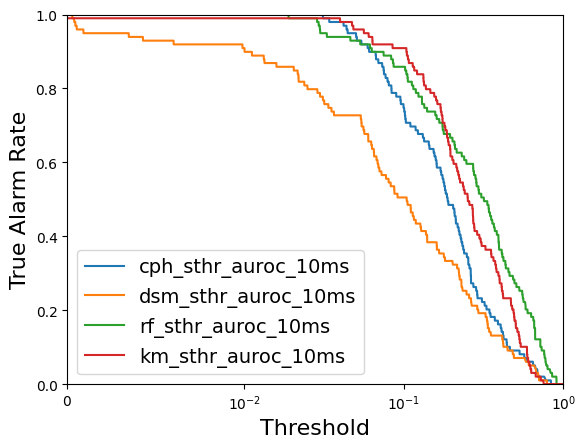

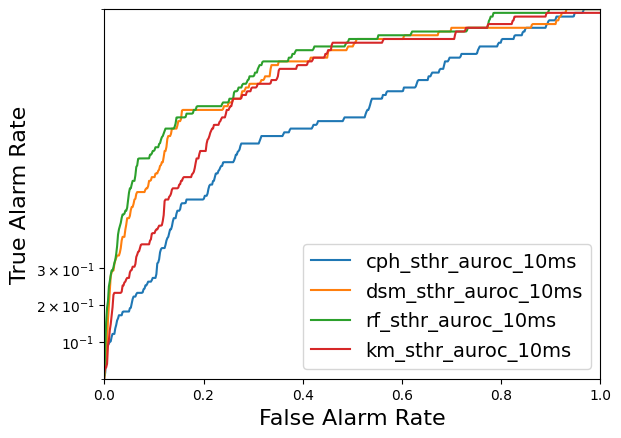

In [2]:
# Pre-compute and cache all values for all experiments
experiment_list = get_experiments(experiment_groups, ['auroc'])
plot_true_alarm_rates_vs_thresholds(experiment_list)
plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)

## Threshold Plots



In [3]:
# Save experiment_groups to disk
import dill
with open('experiment_groups_preliminary_small.pkl', 'wb') as f:
    dill.dump(experiment_groups, f)

In [2]:
# Load experiment_groups from disk
import dill
with open('experiment_groups.pkl', 'rb') as f:
    experiment_groups = dill.load(f)

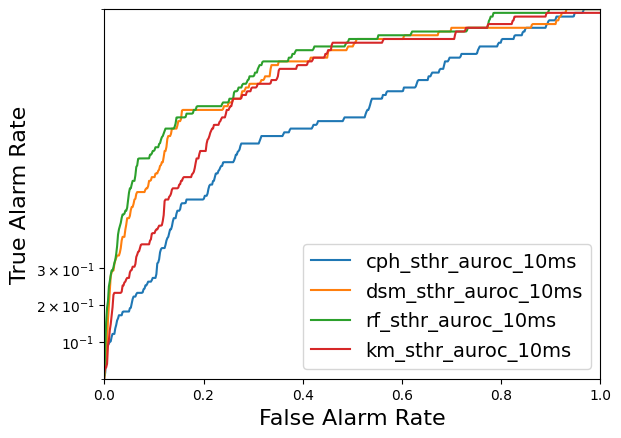

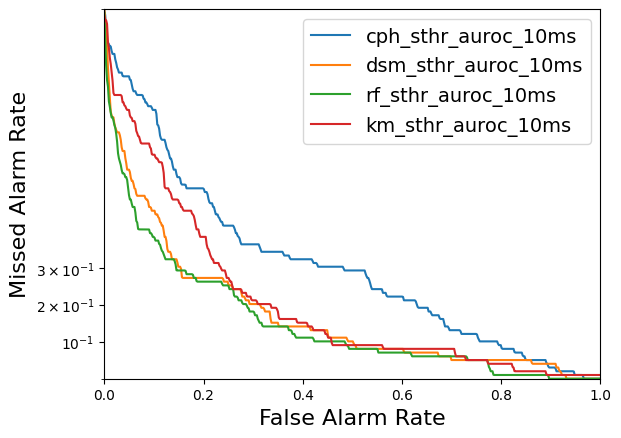

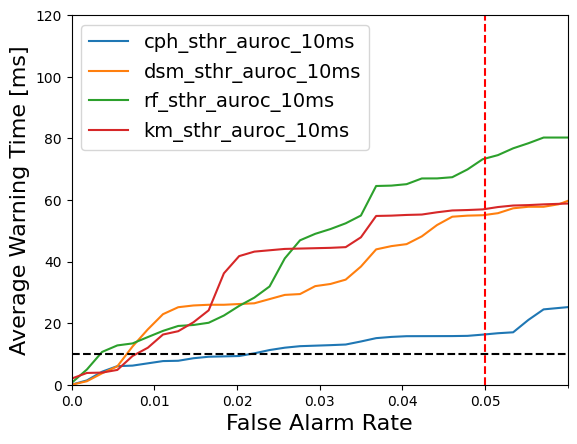

AUROC:	 0.6928384934226044
AUMAL:	 -0.8423997024605263
AUROC:	 0.828638312716782
AUMAL:	 -1.2585408179132487
AUROC:	 0.8483847628037868
AUMAL:	 -1.518723747551782
AUROC:	 0.7956929162386724
AUMAL:	 -0.9803375096386507


In [6]:
required_warning_time = 0.01
experiment_list = get_experiments(experiment_groups, 
                                  ['preliminary_dataset_no_ufo', 'cph', 'auroc', 0.01],
                                  ['preliminary_dataset_no_ufo', 'dsm', 'auroc', 0.01],
                                  ['preliminary_dataset_no_ufo', 'rf', 'auroc', 0.01],
                                  ['preliminary_dataset_no_ufo', 'km', 'auroc', 0.01])

plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_missed_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_avg_warning_times_vs_false_alarm_rates(experiment_list, required_warning_time)
#plot_true_alarm_rates_vs_thresholds(experiment_list)
#plot_false_alarm_rates_vs_thresholds(experiment_list)
#plot_warning_times_vs_thresholds(experiment_list)

for experiment in experiment_list:
    aumal = experiment.evaluate_metric('aumal')
    auroc = experiment.evaluate_metric('auroc')
    print(f"AUROC:\t {auroc}")
    print(f"AUMAL:\t {aumal}")

## ROC Curve

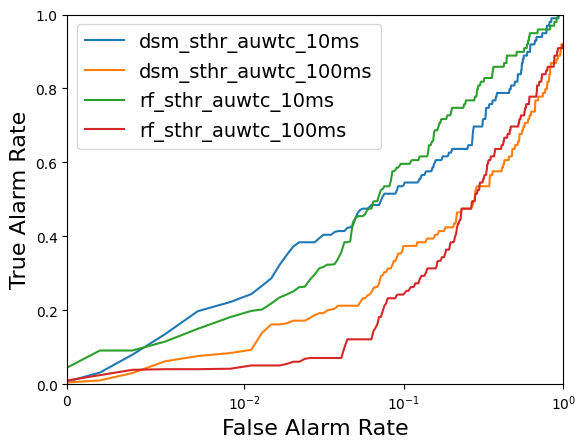

## Area Under Warning Time Curve



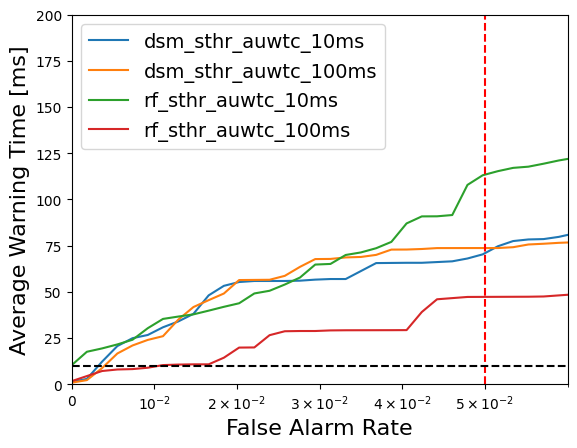